# Structured data

Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import random
import math
import re
import seaborn

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/il/titanic/'

## Create datasets

Get the Kaggle competition data for Titanic and put it on the $Path from above. Then fill out the pandas tables with the data.

In [3]:
table_names = ['train', 'test']

In [4]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [5]:
from IPython.display import HTML

In [6]:
for t in tables: display(t.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### The following returns summarized aggregate information to each table accross each field. This is a good overall view to just start exploring the data inside.

In [7]:
for t in tables: display(DataFrameSummary(t).summary())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891,891,891,NaN,NaN,714,891,891,NaN,891,NaN,NaN
mean,446,0.383838,2.30864,NaN,NaN,29.6991,0.523008,0.381594,NaN,32.2042,NaN,NaN
std,257.354,0.486592,0.836071,NaN,NaN,14.5265,1.10274,0.806057,NaN,49.6934,NaN,NaN
min,1,0,1,NaN,NaN,0.42,0,0,NaN,0,NaN,NaN
25%,223.5,0,2,NaN,NaN,20.125,0,0,NaN,7.9104,NaN,NaN
50%,446,0,3,NaN,NaN,28,0,0,NaN,14.4542,NaN,NaN
75%,668.5,1,3,NaN,NaN,38,1,0,NaN,31,NaN,NaN
max,891,1,3,NaN,NaN,80,8,6,NaN,512.329,NaN,NaN
counts,891,891,891,891,891,714,891,891,891,891,204,889
uniques,891,2,3,891,2,88,7,7,681,248,147,3


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418,418,NaN,NaN,332,418,418,NaN,417,NaN,NaN
mean,1100.5,2.26555,NaN,NaN,30.2726,0.447368,0.392344,NaN,35.6272,NaN,NaN
std,120.81,0.841838,NaN,NaN,14.1812,0.89676,0.981429,NaN,55.9076,NaN,NaN
min,892,1,NaN,NaN,0.17,0,0,NaN,0,NaN,NaN
25%,996.25,1,NaN,NaN,21,0,0,NaN,7.8958,NaN,NaN
50%,1100.5,3,NaN,NaN,27,0,0,NaN,14.4542,NaN,NaN
75%,1204.75,3,NaN,NaN,39,1,0,NaN,31.5,NaN,NaN
max,1309,3,NaN,NaN,76,8,9,NaN,512.329,NaN,NaN
counts,418,418,418,418,332,418,418,418,417,91,418
uniques,418,3,418,2,79,7,8,363,169,76,3


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [8]:
train, test = tables

### We can see that there are 891 entries in the training set and 418 in the test set. This is problematic because we don't have very much data to go off of and typically you have hundreds of thousands or data points.

In [9]:
len(train),len(test)

(891, 418)

# PClass and Sex

### First lets have a look and see if there are some age conditions that contribute to survivability. Overwhelmingly if you are a woman you are likely to be saved. Also, the higher class you were in apparently you were more likely to be saved. Fortunately, both of those items are easily applied to categories later on. So there isn't really anything to extract or do anything with.

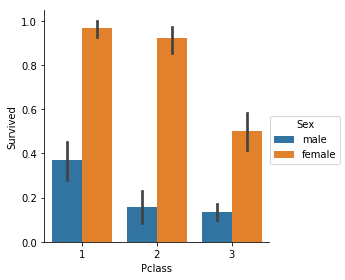

In [10]:
seaborn.factorplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar")

# Age

/home/alex/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


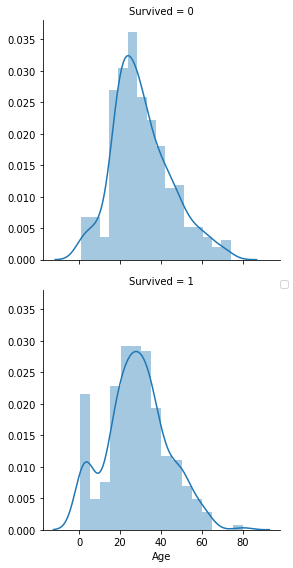

In [11]:
grid = seaborn.FacetGrid(train, row='Survived', size=4)
grid.map(seaborn.distplot, 'Age')
grid.add_legend()

### It seems apparent that babies were especially favored to be saved. In my age ranges I'll attempt to account for that and have a category of infant/toddler to try and make sure we account for this.

### We do have missing data and so looking at the information for those who are missing data seems to show that women who were missing an age all survived from pclass 1 and 2. 

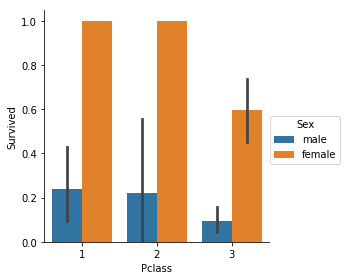

In [12]:
nulls = train[pd.isnull(train['Age'])]
seaborn.factorplot(x="Pclass", y="Survived", hue="Sex", data=nulls, kind="bar")

### Fill in the missing ages with a random smattering between 20 and 38 to fit the general range to reveal outliers

### Backfill ages accounting for sex and class so it doesn't affect the model??

### We can extract some age ranges and use those as they'll probably be more valuable than simply relying on Age as a continuous variable.

In [13]:
#group the ages
for current_table in (train,test):
    current_table.Age = current_table.Age.apply(lambda x: x if x > 0 else random.randint(20,38))
    current_table["AgeRange"]=pd.cut(train['Age'], bins=[0.0, 5.0, 20.0, 40.0, 50.0, 60.0, 100.0]).cat.codes

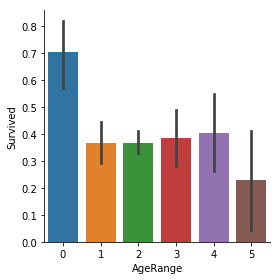

In [14]:
seaborn.factorplot(x="AgeRange", y="Survived", data=train, kind="bar")

### Looks like the youngest kids were taken good care of

# Fare paid

### We will use fare as a continuous variable but also extract a feature of if someone paid more than a certain amount since it seems to affect survivability.

/home/alex/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


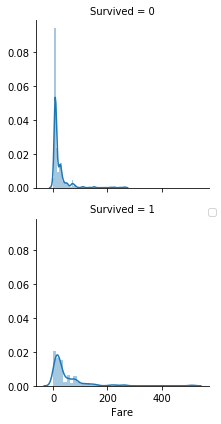

In [15]:
grid = seaborn.FacetGrid(train, row='Survived')
grid.map(seaborn.distplot, 'Fare')
grid.add_legend()

### Looks like if you paid a tiny amount or 0 you had a slim chance of survival.

Before we extract anything we'll use -1 to indicate unknown fare...

### Let's extract a feature that is simply if someone paid a lot and see if that is significant to surviving

In [16]:
def highPriced(amount):
    out = False
    if (amount > 0):
        out = amount > 14
    return out

for current_table in (train,test):
    current_table["Fare"].fillna(0, inplace=True)
    current_table["HighPriced"]=current_table["Fare"].apply( lambda x: highPriced(x))

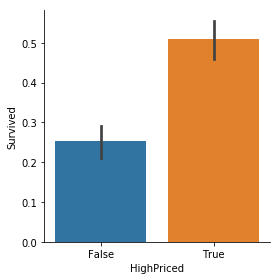

In [17]:
seaborn.factorplot(x="HighPriced", y="Survived", data=train, kind="bar")

In [18]:
for current_table in (train,test):
    current_table["Fare_log"]=current_table["Fare"].apply(lambda x: -10.0 if x==0 else math.log(x))

/home/alex/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


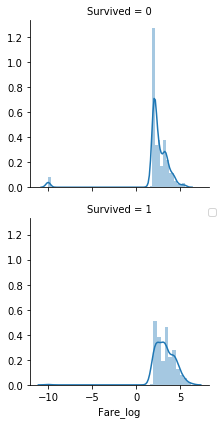

In [19]:
grid = seaborn.FacetGrid(train, row='Survived')
grid.map(seaborn.distplot, 'Fare_log')
grid.add_legend()

### It seems that if you paid more than 14 then you had a higher chance to survive.  So we'll leave this and use it as a category variable later.

# Cabin

### There is probably a loose relationship for each cabin element that might be tied to survivability. The letter indicates a deck. We will extract the letter and see where we end up.

In [20]:
def returnCabinSection(in_str):
    a = re.findall('[a-z]', in_str)
    out = ""
    if (len(a) > 0):
        out = a[0]
    return out

def returnCabinNumber(in_str):
    a = re.findall('[0-9]+', in_str)
    out = "0"
    if (len(a) > 0):
        out = a[0]
    return int(out)

for current_table in (train,test):
    current_table["Cabin"].fillna("", inplace=True)
    current_table["CabinSection"]=current_table["Cabin"].apply( lambda x: returnCabinSection(x.lower()))
    current_table["CabinNumber"]=current_table["Cabin"].apply( lambda x: returnCabinNumber(x))
    current_table["HasCabin"]=current_table.CabinSection != ""

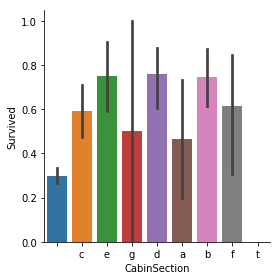

In [21]:
seaborn.factorplot(x="CabinSection", y="Survived", data=train, kind="bar")

### Simply having a cabin seemed to work in your favor

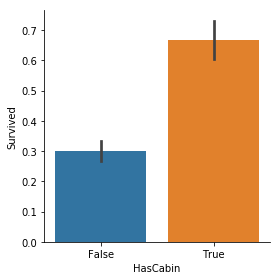

In [22]:
seaborn.factorplot(x="HasCabin", y="Survived", data=train, kind="bar")

/home/alex/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


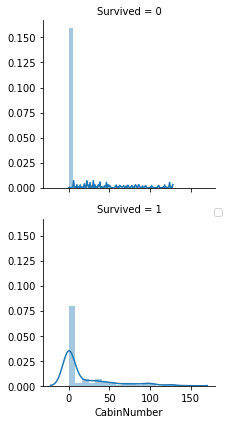

In [23]:
grid = seaborn.FacetGrid(train, row='Survived')
grid.map(seaborn.distplot, 'CabinNumber')
grid.add_legend()

### Cabin Number seems to mean very very little other than maybe having one and not. That'll be accounted for with the deck so we won't use this one.

# Family relationships

### Let's look at the graphs to see how family relationships helped or hurt them

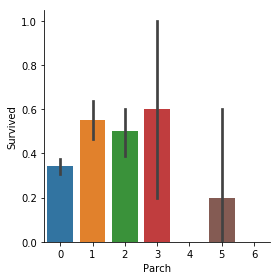

In [24]:
seaborn.factorplot(x="Parch", y="Survived", data=train, kind="bar")

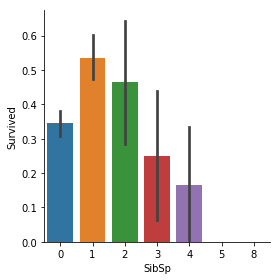

In [25]:
seaborn.factorplot(x="SibSp", y="Survived", data=train, kind="bar")

### It appears that one signficant other be it spouse or sibling had a much higher survivability rate. It also seems like having 1-3 children or parents survived more than others... Not sure what to do with that 

### Let's combine the values for parch and sibsp to get how big the family unit is and see if it becomes clearer as to what is relevant.

In [26]:
for current_table in (train,test):
    current_table["FamilySize"]=current_table.SibSp + current_table.Parch

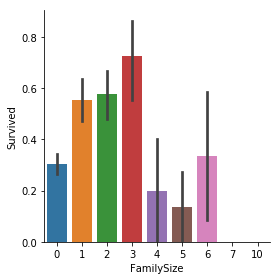

In [27]:
seaborn.factorplot(x="FamilySize", y="Survived", data=train, kind="bar")

### The picture seems clearer in that a family unit of 1-3 had a good chance of surviving and being by yourself or with a large unit didn't work well for you. Can try lots of different things here.

### what about being alone?

In [28]:
for current_table in (train,test):
    current_table["Alone"]=(current_table.SibSp == 0) & (current_table.Parch == 0)

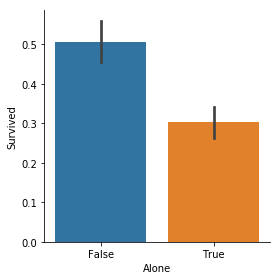

In [29]:
seaborn.factorplot(x="Alone", y="Survived", data=train, kind="bar")

### Yep, alone didn't bode well for you it seems. Yet again. Females that were alone were very very likely to survive.

In [30]:
for current_table in (train,test):
    current_table["Few"]=(current_table.FamilySize > 0) & (current_table.FamilySize < 4)

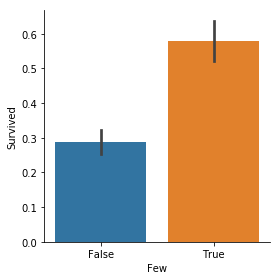

In [31]:
seaborn.factorplot(x="Few", y="Survived", data=train, kind="bar")

# Embarked

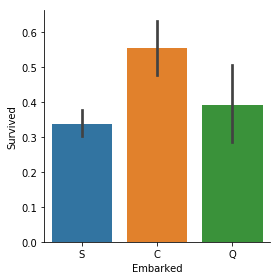

In [32]:
seaborn.factorplot(x="Embarked", y="Survived", data=train, kind="bar")

### If you come from C you are more likely to survive. Fortunately this is an easy category variable.

# Name

### Not a lot we can do with name, but let's extract the title and see how that correlates with everything.

In [33]:
def returnSelectedWord(in_str,selected_words):
    a = re.findall(r"[\w]+", in_str)
    out = ""
    if any(i in a for i in selected_words):
        out = list(set(a) & set(selected_words))[0]
    return out

selected_words = ['mr','miss','mrs','master','ms','dr'] 
for current_table in (train,test):
    current_table["Title"]=current_table["Name"].apply( lambda x: returnSelectedWord( x.lower(),selected_words) )

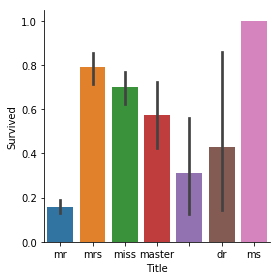

In [34]:
seaborn.factorplot(x="Title", y="Survived", data=train, kind="bar")

### This looks like it adds more weight to the fact that mrs, miss, and ms were all far far far more likely to survive.

# Ticket number

### Probably not super useful but here is an extraction of the ticket number...

In [35]:
for current_table in (train,test):
    current_table["TicketNumber"]=current_table["Ticket"].apply( lambda x: re.findall('[0-9]*$', x)[0])

# Here is a final look at our table in all of its glory

In [36]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,HighPriced,Fare_log,CabinSection,CabinNumber,HasCabin,FamilySize,Alone,Few,Title,TicketNumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,False,1.981001,,0,False,1,False,True,mr,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,True,4.266662,c,85,True,1,False,True,mrs,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,False,2.070022,,0,False,0,True,False,miss,3101282


# Work and Work and Work

## Let's get to the actual learning and training, but first we need a format compatible for a neural net

In [37]:
cat_vars = ['Pclass', 'Sex', 'Embarked', 'Title', 'CabinSection', 'FamilySize', 'AgeRange']

contin_vars = ['Fare_log']

n = len(train); n

891

In [38]:
dep = 'Survived'
joined = train[cat_vars+contin_vars+[dep, 'PassengerId']].copy()

In [39]:
joined_test = test[cat_vars+contin_vars+['PassengerId']].copy()
joined_test[dep] = 0

In [40]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

## Here is a look at a trimmed table with only the variables we care about

In [41]:
joined.head(5)

,Pclass,Sex,Embarked,Title,CabinSection,FamilySize,AgeRange,Fare_log,Survived,PassengerId
0,3,male,S,mr,,1,2,1.981001,0,1
1,1,female,C,mrs,c,1,2,4.266662,1,2
2,3,female,S,miss,,0,2,2.070022,1,3
3,1,female,S,mrs,c,1,2,3.972177,1,4
4,3,male,S,mr,,0,2,2.085672,0,5


In [42]:
apply_cats(joined_test, joined)

In [43]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')
    joined_test[v] = joined_test[v].astype('float32')

In [44]:
samp_size = n
joined_samp = joined.set_index("PassengerId")
joined_test = joined_test.set_index("PassengerId")

We can now process our data...

In [45]:
df, y, nas, mapper = proc_df(joined_samp, dep, do_scale=True)

In [46]:
df_test, _, nas, mapper = proc_df(joined_test, dep, do_scale=True,
                                  mapper=mapper, na_dict=nas)

### Notice that the tables below are now just numbers and training can occur

In [47]:
df.head(3)

,Pclass,Sex,Embarked,Title,CabinSection,FamilySize,AgeRange,Fare_log
PassengerId,,,,,,,,
1,3,2,3,5,1,2,3,-0.390533
2,1,1,1,6,4,2,3,0.808435
3,3,1,3,4,1,1,3,-0.343836


In [48]:
df_test.head(3)

,Pclass,Sex,Embarked,Title,CabinSection,FamilySize,AgeRange,Fare_log
PassengerId,,,,,,,,
892,3,2,2,5,1,1,3,-0.350215
893,3,1,3,6,1,2,3,-0.408940
894,2,2,2,5,1,1,3,-0.238497


In [49]:
#get rid of extra column -- we probably should do something about backfilling...
#df_test = df_test.drop(['Fare_log_na'], axis  =1)

#### Take the last 20% of rows as our validation set.

In [50]:
train_ratio = 0.80
train_size = int(n * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

We can create a ModelData object directly from out data frame.

In [51]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=64,
                                       is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [52]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [53]:
cat_sz

[('Pclass', 4),
 ('Sex', 3),
 ('Embarked', 4),
 ('Title', 8),
 ('CabinSection', 10),
 ('FamilySize', 10),
 ('AgeRange', 7)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [54]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [55]:
emb_szs

[(4, 2), (3, 2), (4, 2), (8, 4), (10, 5), (10, 5), (7, 4)]

In [56]:
max_log_y = np.max(y)

In [57]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01])

In [58]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      16822.754755 1533206574.480447



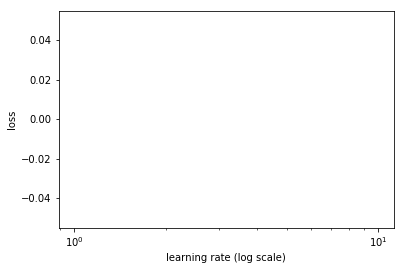

In [59]:
m.sched.plot(100)

In [60]:
lr = 1e-4


### Sample

In [61]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], None, True)

In [62]:
m.fit(lr, 3, metrics=[accuracy_thresh(.5)])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>         
    0      0.30311    0.217038   0.659218  
    1      0.248      0.171742   0.765363         
    2      0.213221   0.148144   0.776536         



[array([0.14814]), 0.7765363165120173]

In [63]:
m.fit(lr, 5, cycle_len=1, metrics=[accuracy_thresh(.5)])

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>         
    0      0.159054   0.139696   0.798883  
    1      0.153146   0.13426    0.798883         
    2      0.153507   0.129566   0.810056         
    3      0.152691   0.128467   0.826816         
    4      0.151516   0.126082   0.804469         



[array([0.12608]), 0.8044692767398983]

In [64]:
m.fit(lr, 2, cycle_len=2, metrics=[accuracy_thresh(.5)])

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>         
    0      0.143759   0.12213    0.821229  
    1      0.143072   0.122622   0.810056         
    2      0.140691   0.122342   0.843575         
    3      0.138694   0.121211   0.843575         



[array([0.12121]), 0.8435754216583081]

### Test

In [65]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], None, True)

In [66]:
m.fit(lr, 6, metrics=[accuracy_thresh(.5)])

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>         
    0      0.225644   0.139218   0.821229  
    1      0.193456   0.124456   0.793296         
    2      0.172477   0.122667   0.804469         
    3      0.159401   0.119984   0.793296         
    4      0.152907   0.11813    0.815642         
    5      0.150551   0.117653   0.826816         



[array([0.11765]), 0.8268156454549821]

In [67]:
m.fit(lr, 8, cycle_len=4, metrics=[accuracy_thresh(.5)])

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>         
    0      0.12886    0.114877   0.843575  
    1      0.126984   0.116252   0.837989         
    2      0.126467   0.115186   0.832402         
    3      0.128293   0.114281   0.843575         
    4      0.131146   0.115741   0.832402         
    5      0.130792   0.114422   0.832402         
    6      0.127249   0.114653   0.843575         
    7      0.127197   0.11497    0.843575         
    8      0.126763   0.113255   0.860335         
    9      0.128358   0.114911   0.854749         
    10     0.129501   0.116659   0.854749         
    11     0.128613   0.116034   0.849162         
    12     0.128373   0.113455   0.843575         
    13     0.129221   0.114277   0.854749         
    14     0.126897   0.118532   0.832402         
    15     0.126335   0.116495   0.832402         
    16     0.128369   0.114088   0.849162         
    17     0.12741    0.114436   0.854749         
    18     0.128465   0.114485   0.854

[array([0.11105]), 0.8603351971956604]

In [68]:
m.save('val0')

In [69]:
m.load('val0')

In [70]:
x,y1=m.predict_with_targs()

In [71]:
y1.shape

(179, 1)

In [72]:
pred_test=m.predict(True)

In [73]:
predictions = np.where(pred_test > 0.5, 1, 0)

In [74]:
flats=predictions.ravel()
flats

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, ..., 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1])

In [75]:
csv_fn=f'{PATH}tmp/sub.csv'

In [76]:
sub = pd.DataFrame({'PassengerId':joined_test.index, 'Survived':flats})[['PassengerId', 'Survived']]
sub.head(10)
sub.to_csv(csv_fn, index=False)

In [77]:
FileLink(csv_fn)

/home/alex/fastai/courses/dl1/data/il/titanic/tmp/sub.csv

## Random Forest stuff... cuz others said it is all the rage

In [78]:
#from sklearn.ensemble import RandomForestRegressor

In [79]:
#((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, y)

In [80]:
#m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
#                          n_jobs=-1, oob_score=True)
#m.fit(trn, y_trn);

In [81]:
#preds = m.predict(val)
#m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, accuracy_thresh(.5)

In [82]:
#preds

In [83]:
#flats=predictions.ravel()
#csv_forest_fn=f'{PATH}tmp/sub_forest.csv'
#sub = pd.DataFrame({'PassengerId':joined_test.index, 'Survived':flats})[['PassengerId', 'Survived']]
#sub.head(3)
#sub.to_csv(csv_forest_fn, index=False)

In [84]:
#FileLink(csv_forest_fn)

### Interestingly I get virtually identical results from random forest as my neural net... others have fared far better with random forest but perhaps fast.ai is making up for my ignorance... /shrug